In [1]:
#Preliminary imports
import numpy as np
import cvxpy as cv


# Assignment 2 (by Maksim Kaledin)

## Excercise 1.4

Consider the problem

$$min \quad 4x_1 + 5\vert x_2 − 1\vert$$
$$s.t. \quad 2\vert x_1 \vert + \vert x_2 − 3 \vert ≤ 5;$$

and reformulate it as a linear programming problem.

### Solution

Let $z_2=x_2-1$ and $x_1=x_{1+}-x_{1-}$. We also can expand absolute values in constraints by switching from one constraint to four:

$$min \quad 4x_1 + 5\vert z_2 \vert$$
$$s.t. \quad 2x_1 + z_2  ≤ 7; \quad 2x_1 - z_2  ≤ 3; \quad -2x_1 + z_2  ≤ 7; \quad -2x_1 - z_2  ≤ 3. $$

Now we need to deal with $\vert z_2 \vert$. Consider new variable $\epsilon_2$, assign $\vert z_2 \vert = \epsilon_2$ in the goal, and add two more constraints:

$$ \epsilon_2 \geq  z_2; \epsilon_2 \geq -z_2. $$

Since the goal is positive with respect to $\epsilon_2$, any optimal solution should assign $\epsilon_2$ either to $z_2$ or $-z_2$, so indeed $\epsilon_2 = \vert z_2 \vert$. To finalize the solution, we need to ensure that all variables are non-negative to correspond to classical LP. Assign $x_1=x_{1+}-x_{1-}, z_2=z_{2+}-z_{2-}$:

$$min \quad 4(x_{1+}-x_{1-})+5\epsilon_2 ~ s.t.$$
$$\quad 2(x_{1+}-x_{1-})+(z_{2+}-z_{2-}) \leq 7,$$
$$\quad 2(x_{1+}-x_{1-})-(z_{2+}-z_{2-}) \leq 3,$$
$$\quad -2(x_{1+}-x_{1-})+(z_{2+}-z_{2-}) \leq 7,$$
$$\quad -2(x_{1+}-x_{1-})-(z_{2+}-z_{2-}) \leq 3,$$
$$ \epsilon_2 \geq  z_2; \epsilon_2 \geq -z_2. $$
$$\quad x_{1+},x_{1-},z_{2+},z_{2-},\epsilon_2 \geq 0.$$

The last condition $\epsilon_2$ is derived from its definition. 




In [2]:
#CVX formulation goes here
#varNames=['x1p','x1m','z2p','z2m','ep2'] #in order not to use quite frequent variable names like x1p
vars14 = cv.Variable(5)

A14 = np.matrix([[2,-2,1,-1,0],
                 [2,-2,-1,1,0],
                 [-2,2,1,-1,0],
                 [-2,2,-1,1,0],
                 [0,0,1,-1,-1],
                 [0,0,-1,1,-1]])

b=np.array([7,3,7,3,0,0])

constraints14 = [ A14*vars14 <= b,
                 vars14 >= np.zeros(5)]
c14 = np.array([4,-4,0,0,5])
obj14 = cv.Minimize(c14*vars14)

problem14 = cv.Problem(obj14, constraints14)
problem14.solve()
print ("status:", problem14.status)
print ("optimal value", problem14.value)
print ("optimal var", vars14.value)
    


status: optimal
optimal value -5.9999999963787936
optimal var [[  7.74471594e-01]
 [  2.27447159e+00]
 [  1.52934485e+00]
 [  1.52934485e+00]
 [  1.26464510e-09]]


## Excercise 1.8 (Road Lighting)

Consider a road divided into $n$ segments and illuminated by $m$ lamps. Let $p_j$ be
the power of the $j$-th lamp. The illumination Ii of the $i$-th segment is assumed to be
$\sum_{j=1}^m a_{ij}p_j$, where aij are known coefficients. Let $I_i^∗$ be the desired illumination of
road $i$.
We are interested in choosing the lamp powers $p_j$ so that the illuminations $I_i$ are close
to the desired illuminations $I_{i}^*$. Provide a reasonable linear programming formulation
of this problem. Note that the wording of the problem is loose and there is more
than one possible formulation.

### Solution

Let $n$ be the number of segments and $m$ be the number of lights available. For now, suppose we somehow obtained positive real matrix $A=(a_{ij})$ of light emissions and electricity is cheap (which is the truth, if, for example, location is powered by hydroenergy plant). So one can formulate the problem of minimizing unsatisfaction from the lighting:
$$
\text{min}_{p}~ \text{max}_{i \in 1,..,n} \left| \sum_{j=1}^m a_{ij}p_j-I_i^*\right| \quad s.t. ~ p_j \in [0,P],
$$
where $P$ is the maximum power which lights can produce. We could easily extend it to more general case if we suppose that all lights have different $P_j$, but it is a redundant complexity. Note that we do not use the average difference, or sum of absolute values as the measure of unsatisfaction. Since we are not interested in cases, when there are very well-illuminated areas and very poor-illuminated ones, the chosen measure looks reasonable: the goal is to minimize all unsatisfactions as much as possible.

Firstly, randomly generate matrix $A$, $P$, and $I_i^*$. To avoid non-realistic results, we should choose $P$ considerably higher than $I_i^*$.

In [3]:
m=5 #number of lights
n=10 #number of segments
P=2

#constraints for random generator
maxInfluence=2
minIlluminance=4
maxIlluminance=6


A18=np.random.uniform(0,maxInfluence,(n,m))
A18=np.matrix(A18)
Idesired=np.random.uniform(minIlluminance,maxIlluminance,(n,1))

In order to process the problem as LP we need to translate it to LP. Consider new variable $\epsilon$ and the following problem:

$$
\text{min} ~\epsilon
$$
$$
s.t. \quad \forall i ~ \epsilon \geq \sum_{j=1}^m a_{ij}p_j - I_i^*,
$$
$$
\quad \quad \epsilon \geq -\sum_{j=1}^m a_{ij}p_j + I_i^*.
$$
$$
\quad \quad p_j \in [0,P]
$$
Since we minimize with respect to $\epsilon$, optimality of the solution iimplies 

$$\epsilon = \text{max}_{i \in 1,..,n} \left| \sum_{j=1}^m a_{ij}p_j-I_i^*\right|.$$

In [4]:
A18_ext = np.block([[A18,-np.ones((n,1))],
                    [-A18,-np.ones((n,1))]]) #nontrivial constraints
#block is new in version 1.13.0!!!!

vars18 = cv.Variable(m+1) #powers + epsilon
constraints18 = [A18_ext*vars18 <= np.block([[Idesired],[-Idesired]]),
                 vars18 >= np.zeros((m+1,1)),
                 vars18[0:m]<= np.ones(m)*P] #epsilon>=0 by definition, but it is much simpler form to write

obj18 = np.zeros(m+1)
obj18[-1]=1# give cost 1 to epsilon
obj18 = cv.Minimize(obj18*vars18)
problem18 = cv.Problem(obj18, constraints18)
problem18.solve()

print ("status:", problem18.status)
print ("optimal value", problem18.value)
print ("optimal var", vars18.value)

status: optimal
optimal value 2.1860013110592353
optimal var [[  2.00000000e+00]
 [  4.50953014e-11]
 [  5.22957712e-01]
 [  7.27819783e-01]
 [  2.00000000e+00]
 [  2.18600131e+00]]


Now we need to verify if the solution is adequate for our problem. In order to do so, we need to define properly matrix $A$. According to [this](https://ru.wikipedia.org/wiki/%D0%9E%D1%81%D0%B2%D0%B5%D1%89%D1%91%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D1%8C), there is an appropriate physical variable called illuminance. We could approximate the illuminance (from one light) of the road segment as the average over it:
$$
a_{ij}=\frac{1}{\Vert x_{i+1}-x_{i}\Vert_2} \int_0^1 \frac{I_j r_0(t)}{(r_0^2(t)+h^2)^{5/2}}dt,
$$
where $x_i$ is the $i$-th waypoint, $r_0(t)=\Vert x_i+t(x_{i+1}-x_i)\Vert_2$ is the distance from the light to point between $x_i$ and $x_{i+1}$, parametrized with $t$, $h$ is the height of the light, $I_j$ is the luminous intensity of the light $j$ (see [this](https://en.wikipedia.org/wiki/Luminous_intensity)). The integral could be easily computed with scipy numerical integration.

The random generator is not the aim of this problem, so we generate quite obvious route with lights in a deterministic manner.




[[ 0.1   0.3   0.4   0.57  0.4   0.6 ]
 [ 0.1   0.25  0.12  0.2   0.5   0.5 ]]
[[ 0.22  0.3   0.5   0.48  0.55]
 [ 0.3   0.15  0.2   0.27  0.55]]


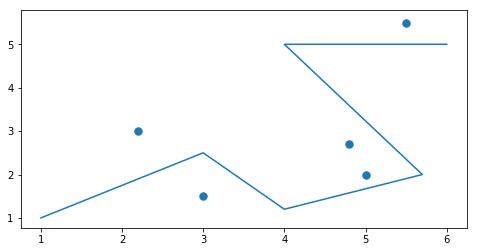

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

scaling=0.1

waypoints_x = np.array([1,3,4,5.7,4,6])
waypoints_y = np.array([1,2.5,1.2,2,5,5])
waypoints = np.block([[scaling*waypoints_x],[scaling*waypoints_y]])
print(waypoints)

lights_x=np.array([2.2,3,5,4.8,5.5])
lights_y=np.array([3,1.5,2,2.7,5.5])
lights = np.block([[scaling*lights_x],[scaling*lights_y]])
print(lights)

f,ax = plt.subplots(figsize=(8,4))

ax.plot(waypoints_x,waypoints_y)
ax.scatter(lights_x,lights_y,s=55)

Idesired=np.zeros((5,1))
Idesired[0]=2
Idesired[1]=4
Idesired[2]=3
Idesired[3]=1
Idesired[4]=4


Here circles represent the lights and the road is drawn with segments. Now compute matrix $A$.

In [6]:
import scipy as sp

h=4 # 4 meters

A18_2 = np.zeros((len(waypoints[0])-1,len(lights[0])))

for i in np.arange(0,len(waypoints[0])-1):
    for j in np.arange(len(lights[0])):
        trange = np.array(np.linspace(0,1,51))
        
        Ft = np.zeros(len(trange))
        for k in np.arange(len(trange)):
            r0=sp.linalg.norm(waypoints[:,i]+trange[k]*(waypoints[:,i+1]-waypoints[:,i])-lights[:,j])
            Ft[k]=np.abs(r0/((np.sqrt(r0**2+h**2))**5))*1e2 #abs for handling direction issues, 1e3 for scaling
        if(i==4):
            print(sp.integrate.simps(Ft,trange),sp.linalg.norm(waypoints[:,i+1]-waypoints[:,i]))
        A18_2[i-1,j]=1/sp.linalg.norm(waypoints[:,i+1]-waypoints[:,i])*sp.integrate.simps(Ft,trange)
        #1e3 just for some scaling reasons
        

print(A18_2)

0.0331116994544 0.20000000000000007
0.0386524897902 0.20000000000000007
0.0293998672908 0.20000000000000007
0.0230228300716 0.20000000000000007
0.00828725553778 0.20000000000000007
[[ 0.10291338  0.04532058  0.09261165  0.09619647  0.24243032]
 [ 0.15511892  0.09633051  0.03262802  0.06276997  0.20170652]
 [ 0.07983153  0.08059281  0.04533013  0.03192124  0.06293811]
 [ 0.1655585   0.19326245  0.14699934  0.11511415  0.04143628]
 [ 0.05379335  0.04661337  0.11672676  0.11404431  0.19199303]]


In [7]:
P=8#maximum power

(n,m)=A18_2.shape
print(n,m)
print(Idesired)
A18_2ext = np.block([[A18_2,-np.ones((n,1))],
                    [-A18_2,-np.ones((n,1))]]) #nontrivial constraints
#block is new in version 1.13.0!!!!

vars18 = cv.Variable(m+1) #powers + epsilon
constraints18 = [A18_2ext*vars18 <= np.block([[Idesired],[-Idesired]]),
                 vars18 >= np.zeros((m+1,1)),
                 vars18[0:m]<= np.ones(m)*P] #epsilon>=0 by definition, but it is much simpler form to write

obj18 = np.zeros(m+1)
obj18[-1]=1# give cost 1 to epsilon
obj18 = cv.Minimize(obj18*vars18)
problem18 = cv.Problem(obj18, constraints18)
problem18.solve()

print ("status:", problem18.status)
print ("optimal value", problem18.value)
print ("optimal var", vars18.value)

5 5
[[ 2.]
 [ 4.]
 [ 3.]
 [ 1.]
 [ 4.]]
status: optimal
optimal value 1.5408916799295316
optimal var [[  8.00000000e+00]
 [  2.65021778e+00]
 [  4.84165673e-08]
 [  3.23805453e+00]
 [  8.00000000e+00]
 [  1.54089168e+00]]


Got [[ 3.1943484 ]
 [ 3.31315295]
 [ 1.45910832]
 [ 2.54089168]
 [ 2.45910832]]
Desired [[ 2.]
 [ 4.]
 [ 3.]
 [ 1.]
 [ 4.]]


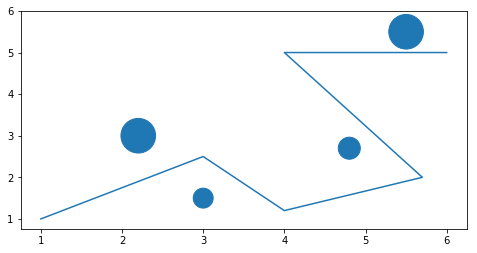

In [8]:
powers = np.array(vars18.value[:-1])
print("Got",A18_2.dot(powers))
print("Desired",Idesired)
f,ax = plt.subplots(figsize=(8,4))

ax.plot(waypoints_x,waypoints_y)
ax.scatter(lights_x,lights_y,s=powers*150)



This chart represents the optimal solution. The radius of circles is the power assigned to corresponding light.

## Excercise 1.5

### Solution

Consider for shorter expressions that all variables are non-negative (it follows from the statement of the problem).

#### 1

It is easy since we know the data.

$$
\text{max}_{x_1,x_2} (9-1.2)x_1+(8-0.9)x_2 \quad s.t. 
$$
$$
\frac{x_1}{4}+\frac{x_2}{3} \leq 90
$$
$$
\frac{x_1}{8}+\frac{x_2}{3} \leq 80
$$


In [9]:
vars15_1 = cv.Variable(2)
A=np.matrix(np.zeros((2,2)))
A[0,0]=1/4
A[0,1]=1/3
A[1,0]=1/8
A[1,1]=1/3

b=np.array([90,80])
constraints15_1 = [A*vars15_1 <= b,
                   vars15_1 >=0]
obj15_1 = cv.Maximize(np.array([7.8,7.1])*vars15_1)
problem15_1 = cv.Problem(obj15_1,constraints15_1)
problem15_1.solve()

print ("status:", problem15_1.status)
print ("optimal value", problem15_1.value)
print ("optimal var", vars15_1.value)

status: optimal
optimal value 2807.9999882490756
optimal var [[  3.59999996e+02]
 [  3.26239653e-06]]


#### 2

##### a

Consider new variables $y_1$, $y_2$ which represent the need for overtime workhours. We will penalize the goal for each overtime hour and this will be the needed LP. Note also that these variables demand a new constraint (the second one) and must be included in testing constraint also (despite we have additional assembly hours, the thesting ones are the same).

$$
\text{max}_{x_1,x_2} 7.8x_1+7.1x_2 - 7*(\frac{y_1}{4}+\frac{y_2}{3})+7.8y_1+7.1y_2 \quad s.t. 
$$
$$
\frac{x_1}{4}+\frac{x_2}{3} \leq 90
$$
$$
\frac{y_1}{4}+\frac{y_2}{3} \leq 50
$$
$$
\frac{x_1+y_1}{8}+\frac{x_2+y_2}{3} \leq 80
$$

In [11]:
vars15_2a = cv.Variable(4)
A=np.matrix(np.zeros((3,4)))
A[0,0]=1/4
A[0,1]=1/3
A[1,0]=1/8
A[1,1]=1/3
A[1,2]=1/8#staging y_1,y_2 for testing
A[1,3]=1/3
#new constraint!
A[2,2]=1/4
A[2,3]=1/4

b=np.array([90,80,50])
constraints15_2a = [A*vars15_2a <= b,
                   vars15_2a >=0]
obj15_2a = cv.Maximize(np.array([7.8,7.1,-7/4+7.8,-7/3+7.1])*vars15_2a)
problem15_2a = cv.Problem(obj15_2a,constraints15_2a)
problem15_2a.solve()

print ("status:", problem15_2a.status)
print ("optimal value", problem15_2a.value)
print ("optimal var", vars15_2a.value)

status: optimal
optimal value 4017.999985130508
optimal var [[  3.59999999e+02]
 [  3.95311072e-07]
 [  1.99999993e+02]
 [  6.84417703e-06]]



##### b

It turned out to be a piecewise-linear goal function, however I have not succeeded in transofrming the problem to LP. So consider another solution, let $\Pi_1$ be a program

$$
\text{max}_{x_1,x_2} 7.8x_1+7.1x_2 \quad s.t. 
$$
$$
\frac{x_1}{4}+\frac{x_2}{3} \leq 90,
$$
$$
\frac{x_1}{8}+\frac{x_2}{3} \leq 80,
$$
$$
1.2x_1 + 0.9x_2 \leq 300,
$$
and $\Pi_2$ be
$$
\text{max}_{x_1,x_2} (9-1.08)x_1+(8-0.81)x_2 - 300 \quad s.t. 
$$
$$
\frac{x_1}{4}+\frac{x_2}{3} \leq 90,
$$
$$
\frac{x_1}{8}+\frac{x_2}{3} \leq 80,
$$
$$
1.2x_1 + 0.9x_2 \geq 300.
$$
Note that $\Pi_1$ represents the solution where we do not agree on a discount while $\Pi_2$ is about agreeing on a discount but demanding to spend $\$300$ for sure.

We can solve $\Pi_1,\Pi_2$ and find out if we need this special offer.

In [13]:
vars15_2b = cv.Variable(2)
A=np.matrix(np.zeros((3,2)))
A[0,0]=1/4
A[0,1]=1/3
A[1,0]=1/8
A[1,1]=1/3
#new constraint!
A[2,0]=1.2
A[2,1]=0.9

b=np.array([90,80,300])
constraints15_2b = [A*vars15_2b <= b,
                   vars15_2b >=0]
obj15_2b = cv.Maximize(np.array([7.8,7.1])*vars15_2b)
problem15_2b = cv.Problem(obj15_2b,constraints15_2b)
problem15_2b.solve()

print ("status:", problem15_2b.status)
print ("optimal value", problem15_2b.value)
print ("optimal var", vars15_2b.value)

status: optimal
optimal value 2185.7142853085256
optimal var [[ 108.57142868]
 [ 188.57142839]]


In [15]:
vars15_2b_2 = cv.Variable(2)
A=np.matrix(np.zeros((3,2)))
A[0,0]=1/4
A[0,1]=1/3
A[1,0]=1/8
A[1,1]=1/3
#new constraint!
A[2,0]=-1.2
A[2,1]=-0.9

b=np.array([90,80,-300])
constraints15_2b_2 = [A*vars15_2b_2 <= b,
                   vars15_2b_2 >=0]
obj15_2b_2 = cv.Maximize(np.array([7.8,7.1])*vars15_2b_2-300)
problem15_2b_2 = cv.Problem(obj15_2b_2,constraints15_2b_2)
problem15_2b_2.solve()

print ("status:", problem15_2b_2.status)
print ("optimal value", problem15_2b_2.value)
print ("optimal var", vars15_2b_2.value)

status: optimal
optimal value 2507.9999988737536
optimal var [[  3.59999999e+02]
 [  4.87173154e-07]]


According to these two solutions, it is better to agree on a discount, because it allows to have greater revenue.

## Excercise 3.12

In [ ]:
# I will send it later